Este script es el paso 1 para analizar la DOE de un pez. Sirve para visualizar los registros y determinar el umbral para la deteccion de DOEs. Ademas tiene una celda para visualizar la FB-DOE en el tiempo y el histograma de frecuencias. 

In [ ]:
#Cargamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import zscore
from scipy.signal import find_peaks, butter, sosfilt
#Definimos parametros
data_folder = '/Volumes/Expansion/datos_GPetersii/datos_GPetersii/Fish6/Object/raw' #Cambiar ruta a la carpeta donde estan los archivos .bin 
n_channels = 3 #cantidad de canales de registro 
sf = 50000 #frecuencia de muestreo

In [ ]:
#obtenemos los archivos disponibles
os.chdir(data_folder) #cambiamos el directorio de trabajo a la carpeta donde tenemos los archivos
files = glob.glob('*.bin')  #guarda los nombres de todos los archivos en nuestra carpeta que son .bin
print('hay ' + str(len(files)) + ' archivos') #imprimimos el numero de archivos .bin que hay en la carpeta

In [ ]:
EOD = np.fromfile(files[45],dtype=np.float64) #En esta linea se carga uno de los archivos, para eso hay que indicar el indice del archivo que queremos cargar
EOD_ch = EOD.reshape((int(EOD.shape[0]/n_channels), n_channels)) #cambiamos la forma de nuestros datos de vector a una matriz donde cada colmna es un canal

In [ ]:
EOD_ch.shape

In [ ]:
#Pre-procesamiento para centrar en 0 los registros de cada canal
for i in range(n_channels):
    medianCh = np.median(EOD_ch[:,i])        
    EOD_ch[:,i] -= int(medianCh)

In [ ]:
#OPCIONAL: filtro de banda, de ser necesario
sos = butter(3, [300,3000], btype='bandpass', fs=10000, output='sos')
for i in range(n_channels):
    EOD_ch[:,i] = sosfilt(sos, EOD_ch[:,i])

In [ ]:
# Combinamos la señal en cada canal para calcular la FB-DOE
EOD = np.square(EOD_ch[:,0], dtype=np.float64) + np.square(EOD_ch[:,1], dtype=np.float64) #agregar termino si se tiene mas de dos canales

In [ ]:
#ploteamos EOD para evaluar la relacion señal/ruido
%matplotlib widget
plt.figure()
plt.plot(EOD_ch[:10000,0])
plt.show()

In [ ]:
%matplotlib widget
# calculamos el z-score y lo ploteamos para determinar el umbral para la deteccion de la DOE 
z_score = zscore(EOD)
plt.figure()
plt.plot(z_score)
plt.show()

In [ ]:
# Calculo de FB-DOE
threshold = 0.02 #cambiar a umbral apropiado
EODTime = np.linspace(0, 20*60, len(EOD))
EOD_peaks, _ = find_peaks(z_score, height = threshold, distance=300) #distancia para petersii 300, para omarorum 150
    
EOD_intervals = np.diff(EODTime[EOD_peaks])
EOD_frequencies = [1/j for j in EOD_intervals]

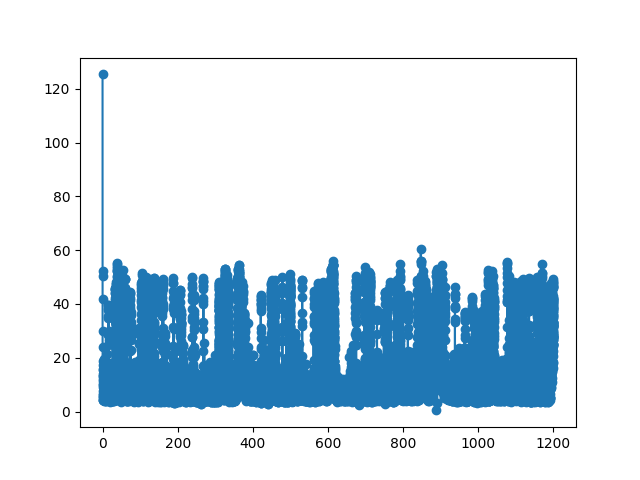

In [14]:
#ploteamos la FB-DOE en el tiempo
plt.figure()
plt.scatter(EODTime[EOD_peaks[:-1]],EOD_frequencies)
plt.plot(EODTime[EOD_peaks[:-1]],EOD_frequencies)

plt.show()

In [ ]:
#ploteamos el histograma de frecuencia
plt.figure()
plt.hist(EOD_frequencies, bins=20)
plt.show()